# 1) Imports

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import ipywidgets as widgets
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, clear_output
import itertools
from tqdm import tqdm



## Colour Palette

In [2]:
# Set the color palette globally
sns.set_palette('tab10')

# 2) Data Preprocess

This database contains statistics on annual imports and exports (including re-exports) of fishery and aquaculture products by reporting country and product in terms of volume and value from 2011 to 2021.


Dataset download link


1.   https://www.fao.org/fishery/statistics-query/en/trade/trade_quantity
2.   https://www.fao.org/fishery/statistics-query/en/home



## Clean Data

In [3]:
# Function to read and clean data
def read_and_clean_data(file_path, trade_mode = 'Exports'):
    data = pd.read_csv(file_path, index_col=['Reporters by continent Name En'])

    # Remove columns with 'flag'
    columns_to_remove = [col for col in data.columns if 'Flag' in col]
    data.drop(columns=columns_to_remove, inplace=True)

    # Filter data by commodity and trade flow
    filtered_data = data[(data['Trade flow Name En'] == trade_mode)]

    return filtered_data.drop(['Trade flow Name En', 'Unit Name'], axis=1)

In [4]:
# Read and clean fish export quantity and value data
fish_export_quantity = read_and_clean_data('/content/trade_quantity (7).csv', trade_mode = 'Exports')
fish_import_quantity = read_and_clean_data('/content/trade_quantity (7).csv', trade_mode = 'Imports')
years = fish_import_quantity.columns[2:]

## View Data format


In [5]:
fish_export_quantity.head()

,Reporting country Name En,FAO major group Name En,2021,2020,2019,2018,2017,2016,2015,2014,...,1985,1984,1983,1982,1981,1980,1979,1978,1977,1976
Reporters by continent Name En,,,,,,,,,,,,,,,,,,,,,
Asia,Afghanistan,Aquatic plants,NaN,NaN,0.880,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,Afghanistan,"Crustaceans &amp; Molluscs, live, fresh, chill...",0.012,0.0020,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,Afghanistan,"Crustaceans and molluscs, prepared or preserved",0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,Afghanistan,"Fish, dried, salted, or smoked",0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,Afghanistan,"Fish, fresh, chilled or frozen",0.600,1.4549,1.865,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
fish_export_quantity.columns

Index(['Reporting country Name En', 'FAO major group Name En', '2021', '2020',
       '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011',
       '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002',
       '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993',
       '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984',
       '1983', '1982', '1981', '1980', '1979', '1978', '1977', '1976'],
      dtype='object')

In [7]:
fish_export_quantity.describe()

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,1985,1984,1983,1982,1981,1980,1979,1978,1977,1976
count,1.158000e+03,1.103000e+03,1.120000e+03,1.118000e+03,1.139000e+03,1.083000e+03,1.069000e+03,1.074000e+03,1.062000e+03,1.069000e+03,...,5.130000e+02,525.000000,516.000000,511.000000,518.000000,505.000000,507.000000,490.000000,487.000000,476.000000
mean,2.949176e+04,2.979732e+04,3.014706e+04,3.034414e+04,2.853165e+04,2.753018e+04,2.759845e+04,2.777740e+04,2.714847e+04,2.698767e+04,...,2.024901e+04,17697.731429,16448.897287,17315.577299,16028.424710,16190.596040,15721.733728,14868.114286,14141.556468,13775.575630
std,1.336112e+05,1.348478e+05,1.400453e+05,1.431277e+05,1.379539e+05,1.292556e+05,1.296748e+05,1.334272e+05,1.303303e+05,1.315442e+05,...,6.934603e+04,57022.758729,53584.562913,58993.106147,47904.352021,49391.981414,49456.940903,46012.087648,46210.404710,46268.954091
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.418300e+00,1.821055e+01,1.616870e+01,1.525000e+01,1.200000e+01,2.000000e+01,1.600000e+01,1.400000e+01,2.000000e+01,1.500000e+01,...,6.500000e+01,36.000000,63.500000,67.000000,38.250000,59.000000,60.000000,69.250000,80.000000,62.500000
50%,4.539380e+02,6.015140e+02,5.346612e+02,5.242855e+02,4.770000e+02,5.630000e+02,4.830000e+02,4.665000e+02,4.655000e+02,3.750000e+02,...,1.058000e+03,749.000000,930.000000,987.000000,827.000000,910.000000,1025.000000,1088.000000,1077.000000,1013.000000
75%,6.863405e+03,8.335162e+03,7.479574e+03,7.402750e+03,7.058500e+03,7.706500e+03,7.258000e+03,7.518250e+03,7.522000e+03,7.826000e+03,...,1.231000e+04,8663.000000,8602.250000,7901.500000,7197.500000,7571.000000,7089.500000,7058.500000,6664.500000,7594.750000
max,2.510316e+06,2.212214e+06,2.192852e+06,2.259853e+06,2.264228e+06,2.180038e+06,2.199004e+06,2.299701e+06,2.132240e+06,2.208741e+06,...,1.109025e+06,781527.000000,755074.000000,772719.000000,455812.000000,465097.000000,530868.000000,473439.000000,461557.000000,594146.000000


In [8]:
fish_export_quantity.dtypes

Reporting country Name En     object
FAO major group Name En       object
2021                         float64
2020                         float64
2019                         float64
2018                         float64
2017                         float64
2016                         float64
2015                         float64
2014                         float64
2013                         float64
2012                         float64
2011                         float64
2010                         float64
2009                         float64
2008                         float64
2007                         float64
2006                         float64
2005                         float64
2004                         float64
2003                         float64
2002                         float64
2001                         float64
2000                         float64
1999                         float64
1998                         float64
1997                         float64
1

In [9]:
fish_export_quantity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1656 entries, Asia to Americas
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Reporting country Name En  1656 non-null   object 
 1   FAO major group Name En    1656 non-null   object 
 2   2021                       1158 non-null   float64
 3   2020                       1103 non-null   float64
 4   2019                       1120 non-null   float64
 5   2018                       1118 non-null   float64
 6   2017                       1139 non-null   float64
 7   2016                       1083 non-null   float64
 8   2015                       1069 non-null   float64
 9   2014                       1074 non-null   float64
 10  2013                       1062 non-null   float64
 11  2012                       1069 non-null   float64
 12  2011                       1056 non-null   float64
 13  2010                       1044 non-null   flo

In [10]:
#fill nan values
#fish_export_quantity.fillna(fish_export_quantity.mean(), inplace=True)
#fish_export_quantity.info()

# 3) Exploratory Data Analysis

## View Global export seafood trade by quantity

In [11]:
def view_global_data(df, trade_mode):
  # Set seaborn style
  sns.set(style="whitegrid")
  years = [str(year) for year in range(1976, 2022)]
  aggregated_df = df.groupby('Reporters by continent Name En')[years].sum().reset_index()
  aggregated_df.set_index('Reporters by continent Name En', inplace=True)
  aggregated_df = aggregated_df.T

  # Create a figure and axis
  plt.figure(figsize=(13, 7))  # Adjust the figure size as needed

  # Plot using seaborn with circular markers and increased line width
  sns.lineplot(data=aggregated_df, markers='o', dashes=False, palette='tab10', linewidth=3.5)

  # Title and labels
  plt.title(f'{trade_mode} Volume Over Time -  Continent wise', fontsize=18, fontweight='bold')
  plt.xlabel('Year', fontsize=12)
  plt.xticks(rotation=90)
  plt.ylabel('Export Volume in MT', fontsize=12)

  # Legend
  plt.legend(title='Continent', loc='best', fontsize=10)

  # Grid
  plt.grid(True)

  # Show the plot
  plt.tight_layout()  # Ensures all elements fit in the figure area
  plt.show()


<ipython-input-11-24f08b57655e>:13: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=aggregated_df, markers='o', dashes=False, palette='tab10', linewidth=3.5)


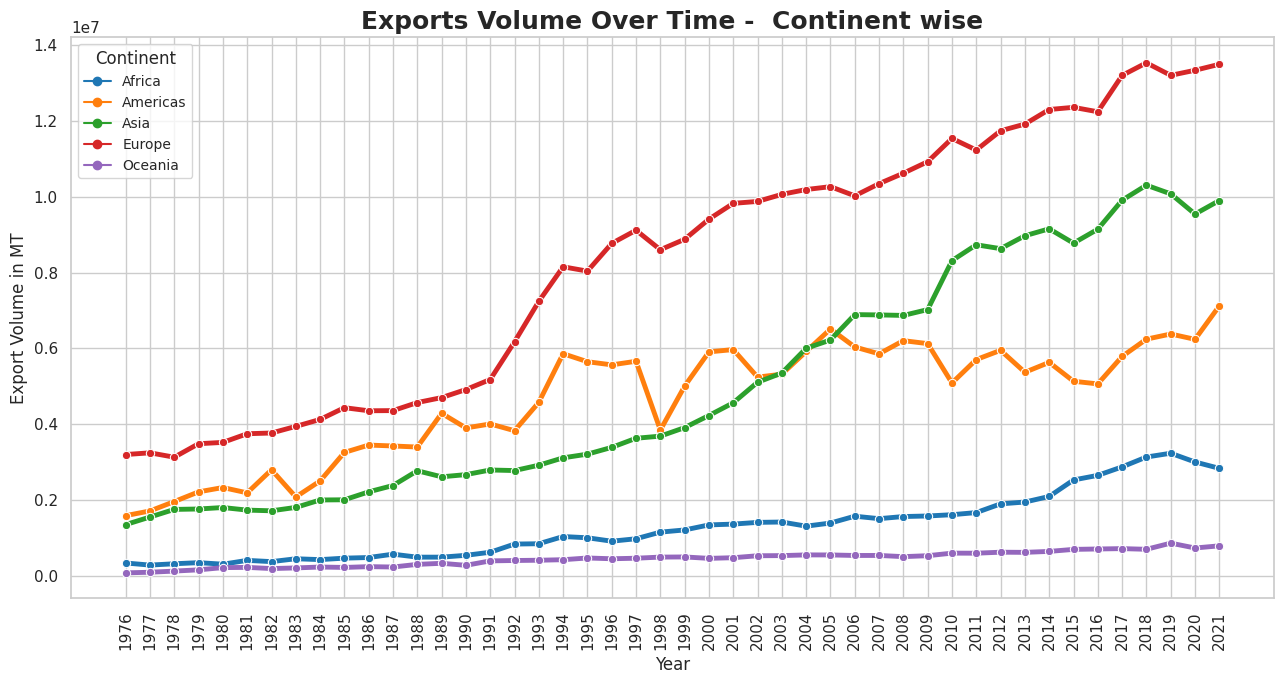

In [12]:
view_global_data(df = fish_export_quantity, trade_mode = 'Exports')

## View Global import seafood trade by quantity

<ipython-input-11-24f08b57655e>:13: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=aggregated_df, markers='o', dashes=False, palette='tab10', linewidth=3.5)


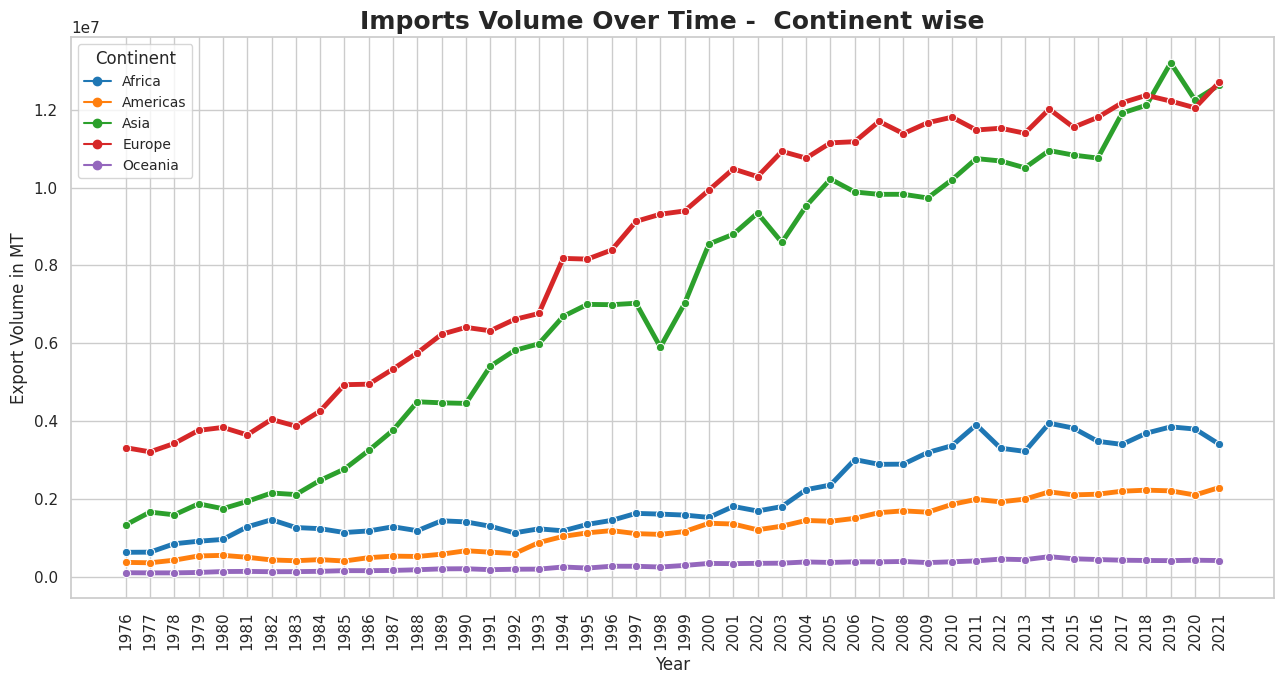

In [13]:
view_global_data(df = fish_import_quantity, trade_mode = 'Imports')

## Trade export volume of countries in a continent

In [14]:
def view_volume_by_continent(df, continent, year='2021', trade_mode="Exports"):
    # Filter data for the selected continent
    #continent_yearly_export = df[df['Reporters by continent Name En'] == continent].reset_index()
    continent_yearly_export = df.loc[df.index == continent]
    selected_years = df.columns[2:]
    country_yearly_export = continent_yearly_export.groupby('Reporting country Name En')[selected_years].sum().reset_index()

    # Sort the values by export volume in descending order for the selected year
    country_yearly_export = country_yearly_export.sort_values(by=year, ascending=False)
    country_yearly_export = country_yearly_export.head(15)
    # Use Seaborn styles
    sns.set(style='whitegrid')

    # Create a bar chart for export volume by country with transposed axes
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=year, y='Reporting country Name En', data=country_yearly_export, palette='viridis')

    # Add a y-axis tick angle (e.g., 45 degrees)
    ax.set_yticklabels(country_yearly_export['Reporting country Name En'], rotation=0, ha='right')

    plt.title(f'{trade_mode} Volume of Countries in {continent} - {year}', fontsize=18, fontweight='bold')
    plt.xlabel(f'{trade_mode} Volume in Tons', fontsize=18, fontweight='bold')
    plt.ylabel('Country', fontsize=18, fontweight='bold')
    plt.grid(True)
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points')
    plt.show()

# Example usage:
# view_volume_by_continent(fish_export_quantity, continent='Asia', year='2021')

In [15]:
continent_widget = widgets.Dropdown(
    options=fish_export_quantity.index.unique(),
    value='Asia',
    description='Continent:'
)

year_widget = widgets.Dropdown(
    options=years,
    value='2021',
    description='Year:'
)

trade_mode_widget = widgets.Dropdown(
    options=['Exports','Imports'],
    value='Exports',
    description='Trade_mode:'
)
# Define a function to update the output
def update_output(continent, year, trade_mode):
    clear_output()  # Clear previous output
    if trade_mode == 'Imports':
      df = fish_import_quantity
    elif trade_mode == 'Exports':
      df = fish_export_quantity
    print(f"Chosen continent: {continent}|| Chosen year: {str(year)}")
    view_volume_by_continent(df, continent = continent, year = year, trade_mode = trade_mode)

# Create an interactive UI with widgets and callback
interactive_plot = widgets.interactive(update_output, continent=continent_widget, year=year_widget, trade_mode = trade_mode_widget)

# Display the interactive UI
display(interactive_plot)


interactive(children=(Dropdown(description='Continent:', options=('Asia', 'Europe', 'Africa', 'Americas', 'Oce…

## Products - Country Specific


In [16]:
def view_product_country(df, year='2021', country = 'China', trade_mode="Exports"):
  filtered_df = df[df['Reporting country Name En'] == country]
  filtered_df_export = filtered_df.sort_values(by=year, ascending=False)
  # Use Seaborn styles
  sns.set(style='whitegrid')
  plt.figure(figsize=(12, 6))
  ax = sns.barplot(x=year, y='FAO major group Name En', data=filtered_df_export, palette='viridis')
  ax.set_yticklabels(filtered_df_export['FAO major group Name En'], rotation=0, ha='right')
  plt.title(f'{trade_mode} products by Country {country} - {year}', fontsize=18, fontweight='bold')
  plt.xlabel(f'{trade_mode} Volume in Tons', fontsize=18, fontweight='bold')
  plt.ylabel('products', fontsize=18, fontweight='bold')
  plt.grid(True)
  for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points')
  plt.show()
#view_product_country(fish_export_quantity, year='2021', country = 'India', trade_mode="Exports")

In [17]:
country_widget = widgets.Dropdown(
    options=fish_export_quantity['Reporting country Name En'].unique(),
    value='China',
    description='Country:'
)

year_widget = widgets.Dropdown(
    options=years,
    value='2021',
    description='Year:'
)

trade_mode_widget = widgets.Dropdown(
    options=['Exports','Imports'],
    value='Imports',
    description='Trade_mode:'
)
# Define a function to update the output
def update_output(country, year, trade_mode):
    clear_output()  # Clear previous output
    if trade_mode == 'Imports':
      df = fish_import_quantity
    elif trade_mode == 'Exports':
      df = fish_export_quantity
    view_product_country(df, year= year, country = country, trade_mode= trade_mode)

# Create an interactive UI with widgets and callback
interactive_plot = widgets.interactive(update_output, country = country_widget, year=year_widget, trade_mode = trade_mode_widget)

# Display the interactive UI
display(interactive_plot)


interactive(children=(Dropdown(description='Country:', index=38, options=('Afghanistan', 'Albania', 'Algeria',…

In [18]:
continent_yearly_export = fish_export_quantity[(fish_export_quantity['Reporting country Name En'] == 'China')]

selected_years = continent_yearly_export.columns[2:]
continent_yearly_export.head()

,Reporting country Name En,FAO major group Name En,2021,2020,2019,2018,2017,2016,2015,2014,...,1985,1984,1983,1982,1981,1980,1979,1978,1977,1976
Reporters by continent Name En,,,,,,,,,,,,,,,,,,,,,
Asia,China,Aquatic plants,2.026149e+04,2.026304e+04,2.411105e+04,20344.0,19082.0,22044.0,18279.0,19393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,China,"Crustaceans &amp; Molluscs, live, fresh, chill...",6.354104e+05,5.761709e+05,6.352944e+05,706103.0,755611.0,819758.0,802335.0,779671.0,...,45800.0,46700.0,37000.0,38000.0,45000.0,41000.0,36000.0,29000.0,31000.0,32000.0
Asia,China,"Crustaceans and molluscs, prepared or preserved",4.371315e+05,3.401155e+05,3.729965e+05,414372.0,389786.0,346005.0,322411.0,363767.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,China,"Fish, dried, salted, or smoked",5.509293e+04,6.400158e+04,8.423174e+04,97706.0,95109.0,78632.0,74882.0,77206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asia,China,"Fish, fresh, chilled or frozen",1.481598e+06,1.718587e+06,2.161609e+06,2175578.0,2264228.0,2180038.0,2061687.0,2192215.0,...,65000.0,63000.0,53000.0,53000.0,51000.0,44000.0,42000.0,38000.0,36000.0,38000.0


In [19]:
aggregated_df = continent_yearly_export.groupby('Reporters by continent Name En')[years].sum().reset_index()
aggregated_df=aggregated_df.drop(['Reporters by continent Name En'],axis = 1)
aggregated_df.head()

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,1985,1984,1983,1982,1981,1980,1979,1978,1977,1976
0,3.727529e+06,3.746061e+06,4.198984e+06,4250354.0,4274503.0,4173900.0,3999296.0,4097809.0,3896453.0,3747614.0,...,117300.0,115200.0,96000.0,95500.0,100000.0,89500.0,80000.0,68000.0,68500.0,72000.0


In [20]:
aggregated_df.columns

Index(['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013',
       '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004',
       '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995',
       '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986',
       '1985', '1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977',
       '1976'],
      dtype='object')

# 4) Arima

## Arima prediction of a country

In [21]:
country = 'Japan'
continent_yearly_export = fish_export_quantity[(fish_export_quantity['Reporting country Name En'] == country)]
selected_years = continent_yearly_export.columns[2:]
aggregated_df = continent_yearly_export.groupby('Reporters by continent Name En')[years].sum().reset_index()
aggregated_df=aggregated_df.drop(['Reporters by continent Name En'],axis = 1)
aggregated_df.head()
# Sample data (replace with your actual data)
actual_data = pd.DataFrame({'Year': aggregated_df.columns[::-1],
                            'Volume': aggregated_df.iloc[0].values[::-1]})

# Convert 'Year' column to integers
actual_data['Year'] = actual_data['Year'].astype(int)



In [22]:
actual_data.head()

,Year,Volume
0,1976,647114.0
1,1977,590598.0
2,1978,752595.0
3,1979,726705.0
4,1980,725835.0


## ACF & PACF pre differencing

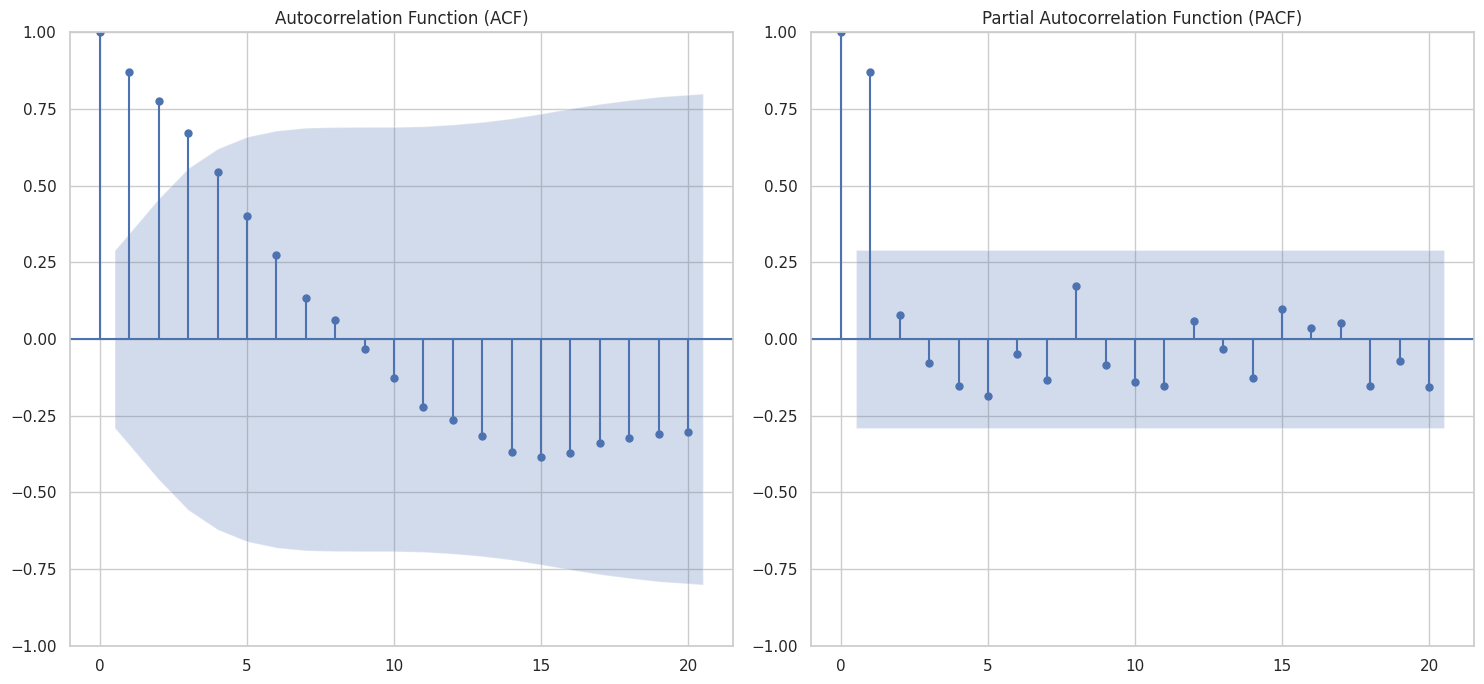

In [23]:
plt.figure(figsize=(15, 7))
# ACF plot
plt.subplot(121)
plot_acf(actual_data['Volume'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(122)
plot_pacf(actual_data['Volume'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')



plt.tight_layout()
plt.show()



In [24]:
# Calculate ACF and PACF values
acf_values = acf(actual_data['Volume'], nlags=20)  # Change the number of lags as needed
pacf_values = pacf(actual_data['Volume'], nlags=20)  # Change the number of lags as needed

# Create DataFrames for ACF and PACF values
acf_df = pd.DataFrame({'Lag': range(len(acf_values)), 'ACF': acf_values})
pacf_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})

# Display ACF and PACF DataFrames
print("ACF Values:")
print(acf_df)

print("\nPACF Values:")
print(pacf_df)


ACF Values:
    Lag       ACF
0     0  1.000000
1     1  0.869295
2     2  0.775243
3     3  0.670696
4     4  0.546070
5     5  0.401727
6     6  0.275567
7     7  0.135410
8     8  0.061715
9     9 -0.031073
10   10 -0.127353
11   11 -0.220417
12   12 -0.263559
13   13 -0.315908
14   14 -0.369467
15   15 -0.383369
16   16 -0.371055
17   17 -0.339040
18   18 -0.321284
19   19 -0.307882
20   20 -0.303662

PACF Values:
    Lag      PACF
0     0  1.000000
1     1  0.888612
2     2  0.099109
3     3 -0.093159
4     4 -0.198148
5     5 -0.253679
6     6 -0.078730
7     7 -0.185172
8     8  0.256378
9     9 -0.094043
10   10 -0.222020
11   11 -0.295199
12   12  0.062232
13   13 -0.019748
14   14 -0.225442
15   15  0.194431
16   16  0.094923
17   17  0.126030
18   18 -0.405862
19   19 -0.250415
20   20 -0.537340


## Differencing

In [25]:
# Perform differencing (d=1, first-order differencing)
differenced_data = actual_data['Volume'].diff(periods=1).dropna()

# Display the differenced data
print("Differenced Data:")
differenced_data.head()


Differenced Data:


1    -56516.0
2    161997.0
3    -25890.0
4      -870.0
5    -32585.0
Name: Volume, dtype: float64

In [26]:
# Calculate ACF and PACF values
diff_acf_values = acf(differenced_data, nlags=20)  # Change the number of lags as needed
diff_pacf_values = pacf(differenced_data, nlags=20)  # Change the number of lags as needed

# Create DataFrames for ACF and PACF values
diff_acf_df = pd.DataFrame({'Lag': range(len(diff_acf_values)), 'ACF': diff_acf_values})
diff_pacf_df = pd.DataFrame({'Lag': range(len(diff_pacf_values)), 'PACF': diff_pacf_values})

# Display ACF and PACF DataFrames
print("ACF Values:")
print(diff_acf_df)

print("\nPACF Values:")
print(diff_pacf_df)


ACF Values:
    Lag       ACF
0     0  1.000000
1     1 -0.126077
2     2  0.002117
3     3  0.056201
4     4  0.121117
5     5 -0.049990
6     6  0.046743
7     7 -0.236415
8     8  0.003732
9     9  0.070993
10   10 -0.002288
11   11 -0.229744
12   12 -0.005792
13   13  0.037391
14   14 -0.156673
15   15 -0.073398
16   16 -0.008745
17   17  0.081259
18   18  0.053080
19   19  0.067210
20   20 -0.068497

PACF Values:
    Lag      PACF
0     0  1.000000
1     1 -0.128943
2     2 -0.014655
3     3  0.059619
4     4  0.151542
5     5 -0.018854
6     6  0.041096
7     7 -0.300453
8     8 -0.095446
9     9  0.091346
10   10  0.074836
11   11 -0.232369
12   12 -0.137757
13   13  0.030907
14   14 -0.287702
15   15 -0.164845
16   16  0.001254
17   17  0.258159
18   18  0.087083
19   19  0.108991
20   20 -0.078141


In [27]:
diff_acf_df.tail()

,Lag,ACF
16,16,-0.008745
17,17,0.081259
18,18,0.053080
19,19,0.067210
20,20,-0.068497


In [28]:
diff_pacf_df.tail()

,Lag,PACF
16,16,0.001254
17,17,0.258159
18,18,0.087083
19,19,0.108991
20,20,-0.078141


## ACF & PACF post differencing

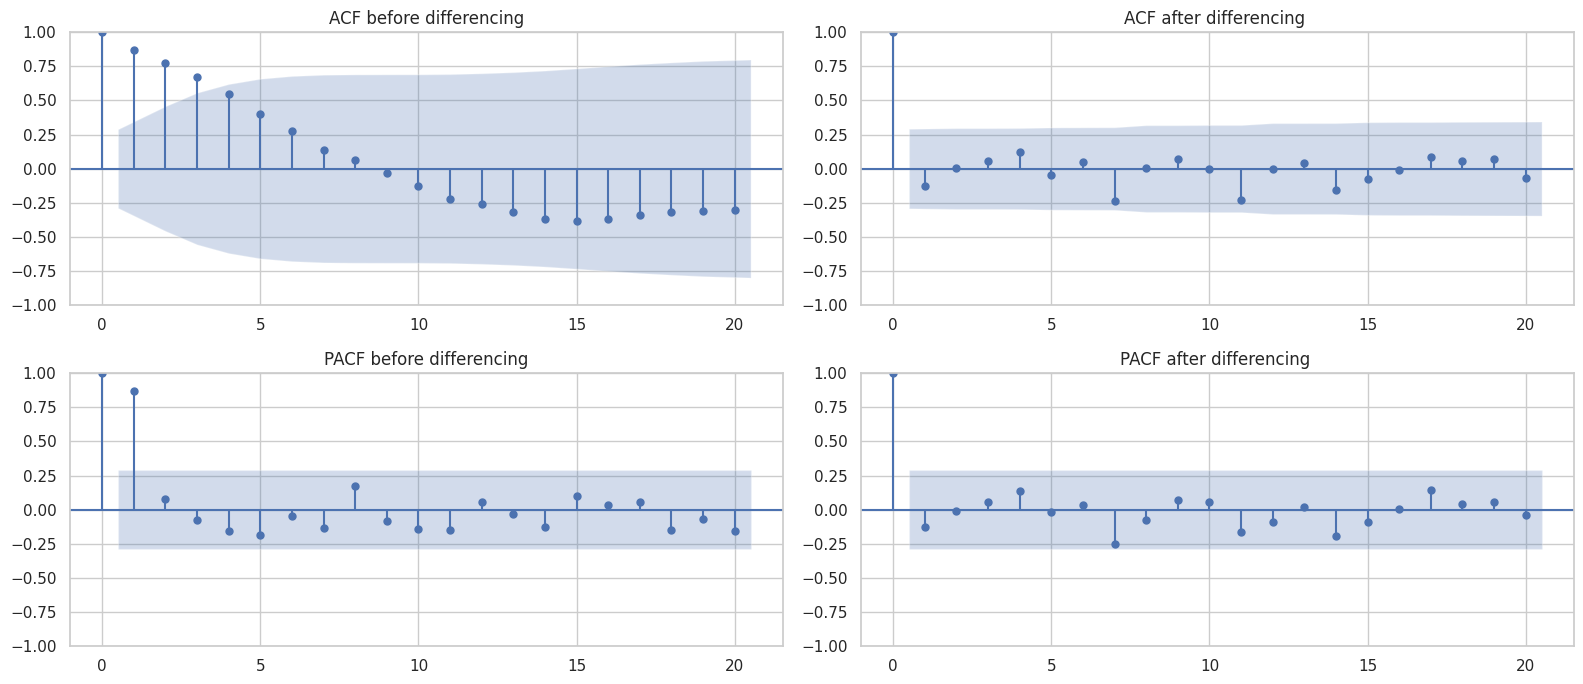

In [29]:
plt.figure(figsize=(16, 7))
# ACF plot
plt.subplot(221)

plot_acf(actual_data['Volume'], lags=20, ax=plt.gca())
plt.title('ACF before differencing')

# After differencing ACF plot
plt.subplot(222)
plot_acf(differenced_data, lags=20, ax=plt.gca())
plt.title('ACF after differencing ')

# PACF plot
plt.subplot(223)
plot_pacf(actual_data['Volume'], lags=20, ax=plt.gca())
plt.title('PACF before differencing')

# After differencing PACF plot
plt.subplot(224)
plot_pacf(differenced_data, lags=20, ax=plt.gca())
plt.title('PACF after differencing ')

plt.tight_layout()
plt.show()



## Predict on normal data

In [30]:
def fit_arima_model1(data, p, d, q, flag = False):
    # Fit an ARIMA model to the data
    model = sm.tsa.ARIMA(data, order=(p, d, q))  # Corrected order argument
    results = model.fit()

    # Make forecasts for future years
    forecast_steps = 5  # Replace with the number of years you want to forecast
    max_year = data.index.max()  # Find the maximum year in the data
    forecast_years = range(max_year +1, max_year +1+ forecast_steps)

    forecast = results.forecast(steps=forecast_steps)

    # Add the predicted values to the DataFrame
    predicted_data = pd.DataFrame({'Year': forecast_years, 'Volume': forecast})

    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data, marker='o', color='blue', label='Actual')
    plt.plot(predicted_data['Year'], predicted_data['Volume'], marker='o', color='red', label='Predicted')

    # Connect the actual and predicted points with a line
    plt.plot([data.index.max(), predicted_data['Year'].min()],
             [data.iloc[-1], predicted_data['Volume'].iloc[0]],
             linestyle='--', color='green', label='Line')

    plt.xlabel('Year')
    plt.ylabel('Volume')
    plt.title('Annual Export Volume with Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the predicted values
    print("Predicted values for future years:")
    for year, value in zip(predicted_data['Year'], predicted_data['Volume']):
        print(f"Year {year}: {value:.2f}")



In [31]:
actual_data.head()

,Year,Volume
0,1976,647114.0
1,1977,590598.0
2,1978,752595.0
3,1979,726705.0
4,1980,725835.0


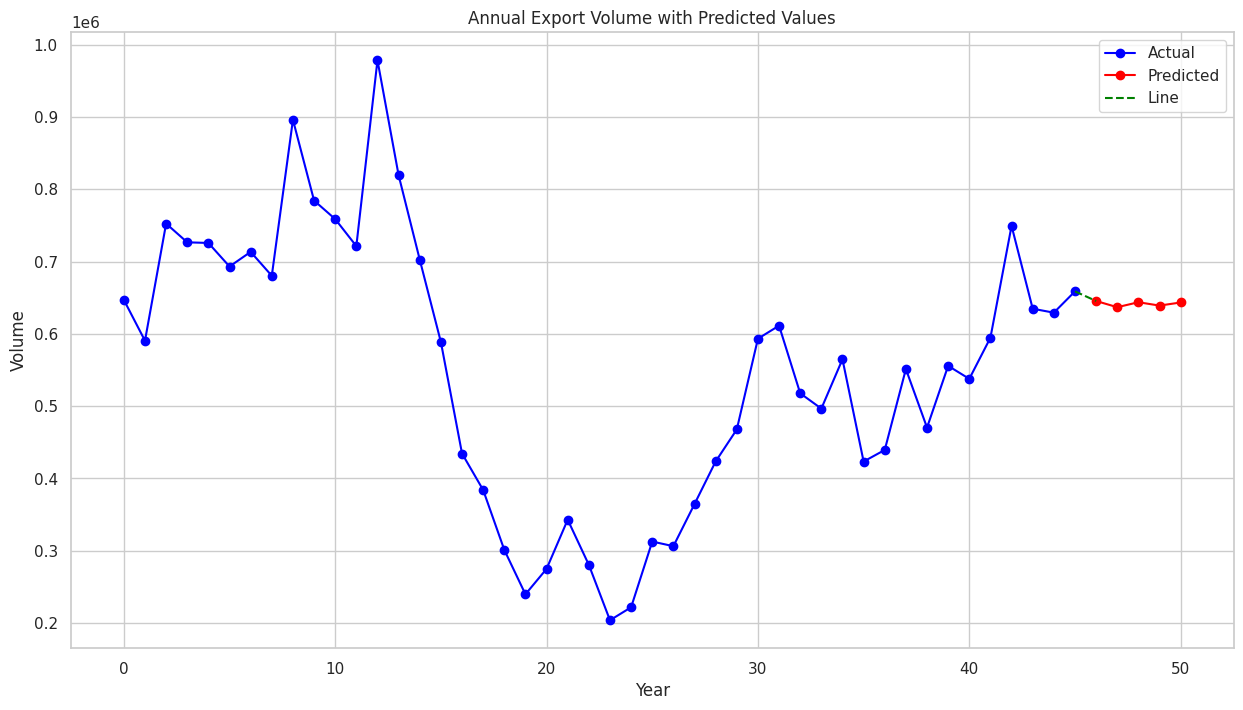

Predicted values for future years:
Year 46: 645544.93
Year 47: 636951.77
Year 48: 643820.35
Year 49: 639196.99
Year 50: 643472.07


In [32]:
#predict on normal data

fit_arima_model1(actual_data['Volume'],p=1,d=1, q=4, flag = False)

## predict on differenced data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

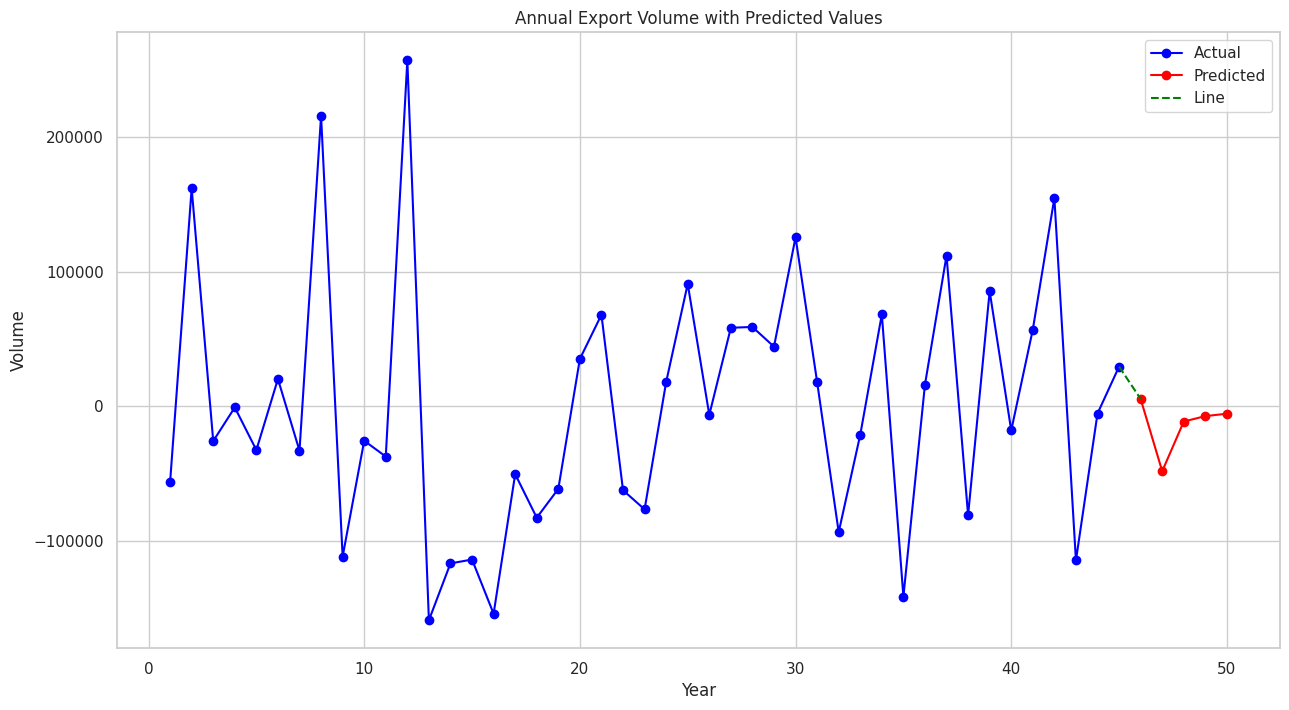

Predicted values for future years:
Year 46: 5440.39
Year 47: -48302.49
Year 48: -11376.65
Year 49: -7330.02
Year 50: -5564.01


In [33]:
#predict on differenced  data
fit_arima_model1(differenced_data,p=1,d=0,q=5)

## AIC

AIC (Akaike Information Criterion):


*  A lower AIC value indicates a better trade-off between model fit and complexity.



In [34]:
# Define a range of values for p and q
p_values = range(0, 5)  # Adjust the range as needed
d_values = range(0, 2)
q_values = range(0, 5)  # Adjust the range as needed

best_aic = float("inf")  # Initialize the best AIC value to positive infinity
best_order = (0, 0)     # Initialize the best order (p, q) to (0, 0)

# Perform grid search
for p in p_values:
    for q in q_values:
        try:
            # Fit an ARIMA model with the current combination of p and q
            model = sm.tsa.ARIMA(actual_data['Volume'], order=(p, 0, q))
            results = model.fit()

            # Calculate AIC (Akaike Information Criterion)
            aic = results.aic

            # Update the best order if the current model has a lower AIC
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)

        except Exception as e:
            continue

print(f"Best AIC: {best_aic}")
print(f"Best Order (p, q): {best_order}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

Best AIC: 1188.055309201951
Best Order (p, q): (1, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## ADF Stat

In [35]:
# Perform the ADF test
result = sm.tsa.adfuller(actual_data['Volume'])

# Extract and print the ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print("Conclusion: Reject the null hypothesis (H0)")
    print("The data is likely stationary.")
else:
    print("Conclusion: Fail to reject the null hypothesis (H0)")
    print("The data is likely non-stationary.")


ADF Statistic: -1.6836207749678032
p-value: 0.43957068951111805
Critical Values:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937
Conclusion: Fail to reject the null hypothesis (H0)
The data is likely non-stationary.


# 5) Sarima

## Functions

### load Data

In [36]:
def generate_data(fish_export_quantity, country='Japan'):
    # Filter data for the specified country
    country_data = fish_export_quantity[fish_export_quantity['Reporting country Name En'] == country]

    # Select columns representing years
    selected_years = country_data.columns[2:]

    # Group by continent and sum the yearly exports
    aggregated_df = country_data.groupby('Reporters by continent Name En')[selected_years].sum().reset_index()

    # Extract the total volume for the chosen country
    country_total = aggregated_df.iloc[0].values[1:]

    # Create a DataFrame with 'Year' and 'Volume' columns
    actual_data = pd.DataFrame({'Year': selected_years, 'Volume': country_total})

    # Convert 'Year' column to integers
    actual_data['Year'] = actual_data['Year'].astype(int)
    actual_data = actual_data.sort_values(by='Year', ascending=True)
    actual_data.set_index('Year', inplace=True)

    return actual_data

### convert seasonality

In [37]:
def convert_seasonality(data):
    # Copy the input DataFrame to avoid modifying the original data

    df = data.copy()
    df.index = pd.to_datetime(df.index, format='%Y')

    # Ensure the 'Volume' column is numeric (convert to float if needed)
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')  # 'coerce' will set non-numeric values to NaN

    # Create a new DataFrame with a complete date range with daily frequency
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')  # Use 'D' for daily frequency

    df_daily = pd.DataFrame(index=date_range)

    # Merge the original DataFrame with the complete date range DataFrame
    df_daily = df_daily.merge(df, how='left', left_index=True, right_index=True)

    # Perform linear interpolation using NumPy for missing values
    df_daily['Volume'] = np.interp(df_daily.index, df_daily.dropna().index, df_daily['Volume'].dropna())

    # Resample the daily data to monthly frequency ('M')
    df_monthly = df_daily.resample('M').mean()


    return df_monthly

### Splitting the data into train and test datasets

In [38]:
def train_test_split(data):
  # Split the data into training and testing sets
  train_size = int(len(data) * 0.8)  # Adjust the split ratio as needed
  train_data, test_data = data['Volume'][:train_size], data['Volume'][train_size:]
  return train_data, test_data

### find_best_sarima

In [39]:
def find_best_sarima(train_data):
    # Define the ranges for p, d, q, P, D, and Q
    p_values = range(0, 3)  # Adjust the range as needed
    d_values = range(0, 2)  # Adjust the range as needed
    q_values = range(0, 3)  # Adjust the range as needed
    seasonal_period = 12  # Adjust the seasonal period based on your data's seasonality

    seasonal_pdq = [(p, d, q) for p, d, q in itertools.product(p_values, d_values, q_values)]

    best_aic = float("inf")
    best_order = (0, 0, 0)
    best_seasonal_order = (0, 0, 0, 0)

    # Wrap the loops with tqdm for a progress bar
    for order in tqdm(seasonal_pdq, desc="Grid Search"):
        p, d, q = order
        for seasonal_order in seasonal_pdq:
            P, D, Q = seasonal_order
            # Fit a SARIMA model with the current combination of orders
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                sarima_model = sm.tsa.SARIMAX(
                    train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period)
                )
                results = sarima_model.fit()

                # Calculate AIC (Akaike Information Criterion)
                aic = results.aic

                # Update the best orders if the current model has a lower AIC
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, seasonal_period)

    print(f"Best AIC: {best_aic}")
    print(f"Best Order (p, d, q): {best_order}")
    print(f"Best Seasonal Order (P, D, Q, S): {best_seasonal_order}")
    return best_order, best_seasonal_order


### fit_sarima_model

In [40]:
import warnings

def fit_sarima_model(best_order, best_seasonal_order, train_data):
  # Fit the best SARIMA model on the training data
  p, d, q = best_order
  P, D, Q, S = best_seasonal_order
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    sarima_model = sm.tsa.SARIMAX(
        train_data, order=(p, d, q), seasonal_order=(P, D, Q, 12)
    )
    results = sarima_model.fit()
  return results


### sarima_forecast_test_data

In [41]:
def sarima_forecast_test_data(results, test_data):
  # Make forecasts for the test data
  forecast_steps = len(test_data)  # Adjust the number of steps
  forecast = results.get_forecast(steps=forecast_steps)

  # Make forecasts for the future years
  forecast_values = forecast.predicted_mean   # Scale down the predictions to match the test data scale
  forecast_ci = forecast.conf_int(alpha=0.95)
  offset = np.mean((forecast_values - test_data.values))
  forecast_values = forecast_values - offset

  # Plot the original data and the forecasts for the test data
  plt.figure(figsize=(15, 8))
  plt.plot(test_data.index, test_data, marker='o', color='blue', label='Actual')
  plt.plot(test_data.index, forecast_values, marker='o', color='red', label='Predicted')

  plt.xlabel('Year')
  plt.ylabel('Volume')
  plt.title('Annual Export Volume with Predicted Values (Test Data)')
  plt.legend()
  plt.grid(True)
  plt.show()
  return forecast, offset

In [43]:
def generate_lag_MA(actual_data):# Define the number of lag periods and moving average windows
  num_lags = 3  # Adjust as needed
  window_sizes = [3, 5]  # Adjust as needed

  # Create lagged values
  for lag in range(1, num_lags + 1):
      actual_data[f'Lag_{lag}'] = actual_data['Volume'].shift(lag)

  # Create moving averages
  for window_size in window_sizes:
      actual_data[f'Moving_Avg_{window_size}'] = actual_data['Volume'].rolling(window=window_size).mean()

  # Drop rows with NaN values created by lagging and rolling mean
  actual_data = actual_data.dropna()

  # Now, 'actual_data' contains lagged values and moving averages as additional features
  print(actual_data.head())
  return actual_data


### sarima forecast future

In [42]:
def forecast_sarima_future(data, results, offset, future_years=5):
    # Find the last year in the available data
    last_year = data.index.max()

    # Make forecasts for the future years
    forecast = results.get_forecast(steps=future_years)
    forecast_values = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.95)

    forecast_values = forecast_values - offset

    # Plot the forecasts for the future years and historical data separately
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(data.index, data, marker='o', color='blue', label='Historical Data')

    # Plot future predictions
    future_years_range = range(last_year, last_year + 1 + future_years)
    plt.plot(future_years_range, pd.concat([pd.Series([data.iloc[-1]]), forecast_values]), marker='o', color='green', label='Future Predictions')
    range_list = list(future_years_range)
    range_list = range_list[1:]
    future_years_range = range(range_list[0],range_list[-1]+1)
    plt.fill_between(
        future_years_range,forecast_ci.iloc[:, 0]-offset,forecast_ci.iloc[:, 1]-offset, color='green', alpha=0.5, label='95% CI'
    )

    plt.xlabel('Year')
    plt.ylabel('Volume')
    plt.title(f'Annual Export Volume with Predicted Values (Next {future_years} Years)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
#forecast_sarima_future(train_data, results, offset, future_years=15)

### generate lag and MA

## Execution

In [44]:
## Generate Data
actual_data = generate_data(fish_export_quantity, country='Japan')

In [45]:
#OG_data = actual_data.copy()
#actual_data = convert_seasonality(actual_data)

In [46]:
# Convert to float if not already
train_data, test_data = train_test_split(actual_data)
train_data = train_data.astype(float)
test_data = test_data.astype(float)
len(actual_data),len(train_data),len(test_data)

(46, 36, 10)

<Axes: xlabel='Year'>

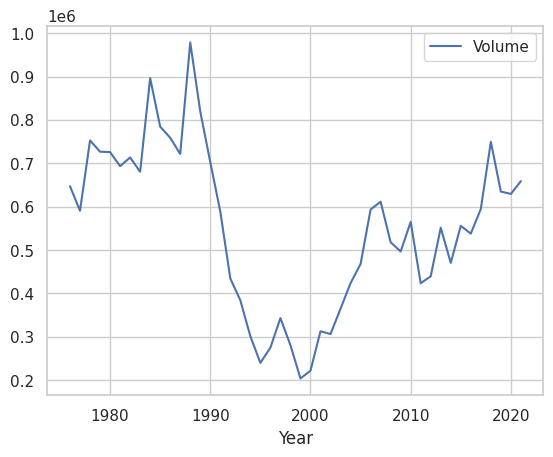

In [47]:
actual_data.plot()

In [50]:
## find best order of pdq, PDQ
best_order, best_seasonal_order = find_best_sarima(train_data)

Grid Search: 100%|██████████| 18/18 [01:33<00:00,  5.22s/it]

Best AIC: 609.402265792973
Best Order (p, d, q): (2, 1, 0)
Best Seasonal Order (P, D, Q, S): (2, 1, 0, 12)


In [51]:
## Train the model
results = fit_sarima_model(best_order, best_seasonal_order, train_data)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Volume   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -299.701
Date:                            Thu, 19 Oct 2023   AIC                            609.402
Time:                                    23:34:11   BIC                            615.080
Sample:                                         0   HQIC                           610.830
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2475      0.398      0.623      0.534      -0.532       1.027
ar.L2          0.3276      0.401      0.818      0.414      -0.458       1.113
ar.S.L12      -0.3869      0.510     -0.759      0.448      -1.386       0.612
ar.S.L24      -0.5441      0.276     -1.973      0.048      -1.084      -0.004
sigma2      1.782e+10   1.01e-11   1.77e+21      0.000    1.78e+10    1.78e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.77   Prob(JB):                         0.63
Heteroskedasticity (H):               4.12   Skew:                             0.42
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+37. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


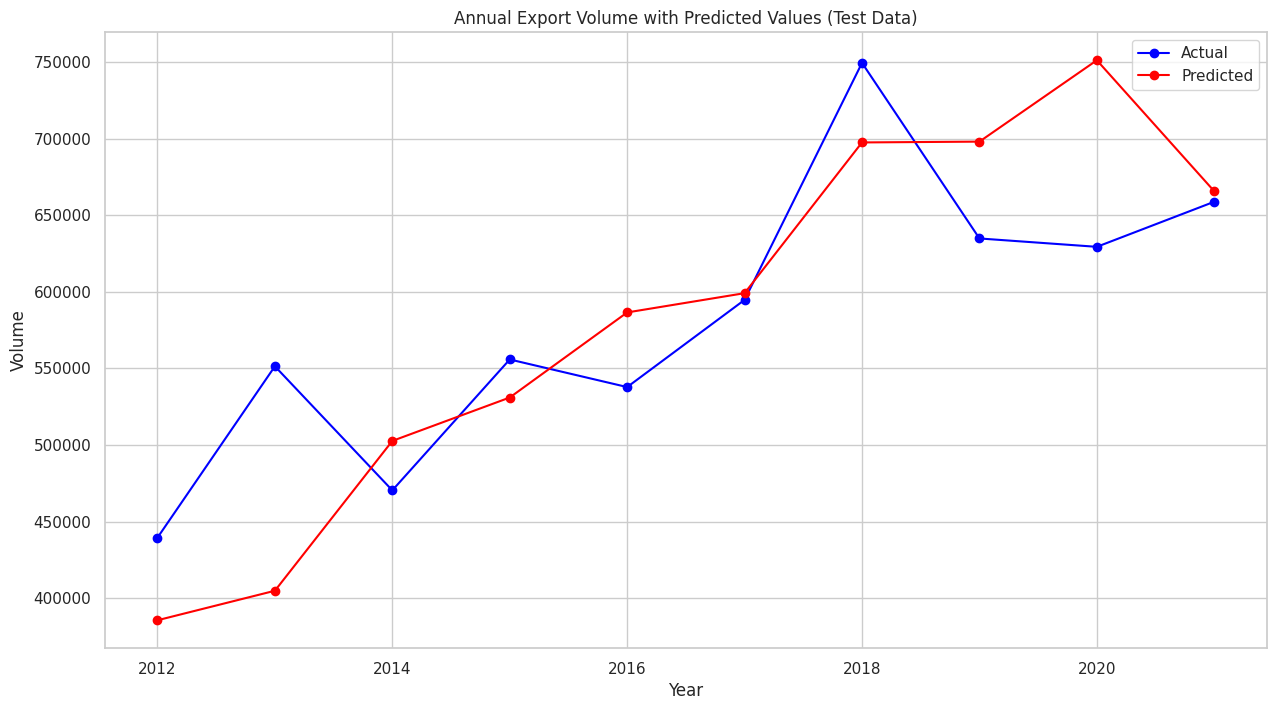

In [52]:
## Forecast on test_data
preds, offset = sarima_forecast_test_data(results, test_data)

In [53]:
s = preds.conf_int()
s.head(5)

,lower Volume,upper Volume
36,493167.652900,1.016511e+06
37,355729.742614,1.192478e+06
38,273273.788563,1.470581e+06
39,136299.745333,1.664211e+06
40,32003.314266,1.879618e+06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


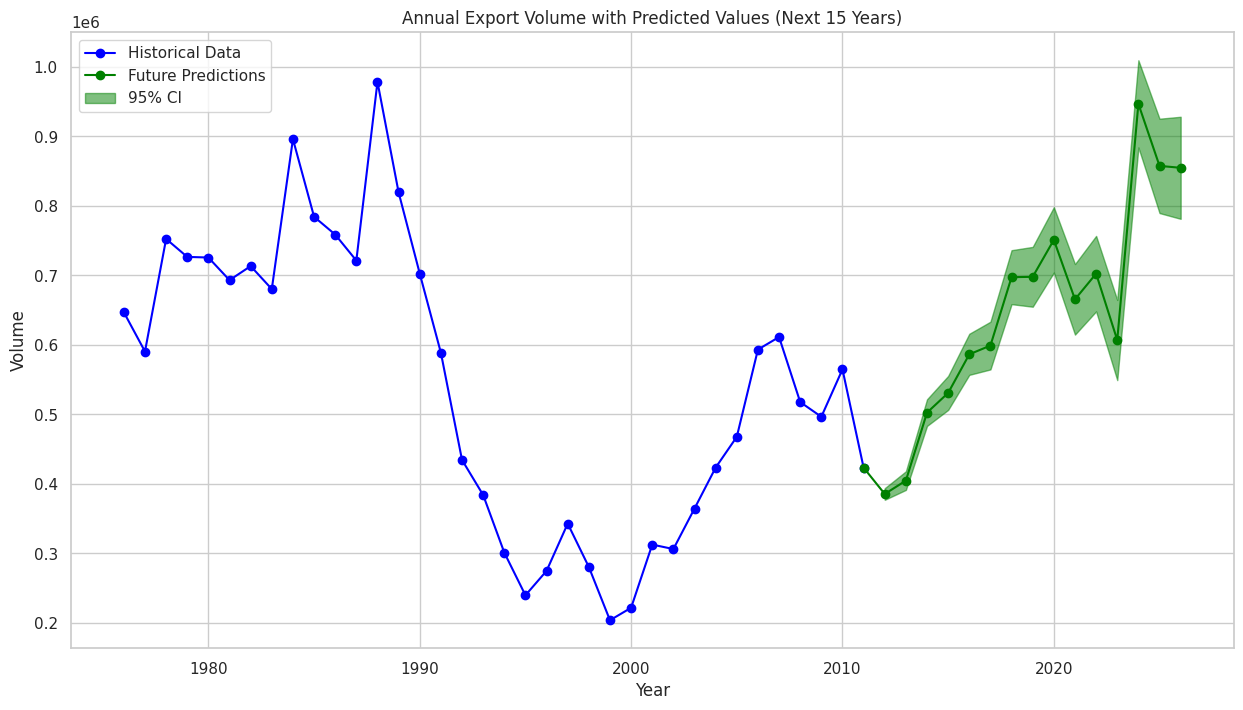

In [54]:
## forecast n years into future
forecast_sarima_future(train_data, results, offset, future_years=15)